In [1]:
print(1)


1


In [2]:
import ir_datasets
import email
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
import gc
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from config import *
import re
import numpy as np

/scratch/2469038g/miniconda3/envs/ryanenv2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data set-up, pre-processing and model set-up, evaluation metrics, experiment set-up

In [3]:
import sys
sys.path.append("../scripts/")

In [4]:
from dataset import load_sara
from eval import jupyter_evaluation
from model import llm_experiment, post_process_split_docs, llm_inference
from models import get_model_version
from preprocess_sara import proccutit


#s = load_sara()
#proc = proccutit(s)
#tokenizer, model = get_model_version('get_mistral', "mistralai/Mistral-7B-Instruct-v0.2", 'main', 'auto')
#jupyter_evaluation(labels, preds)
#llm_experiment(dataset, prompt_strategy, model, tokenizer, end_prompt=None):
#post_process_split_docs(mr, fpr, pre, df)

In [5]:
tokenizer, model = get_model_version('get_model', "mistralai/Mistral-7B-Instruct-v0.2", "main", "auto")

tokenizer_config.json: 100%|██████████| 1.46k/1.46k [00:00<00:00, 653kB/s]
tokenizer.model: 100%|██████████| 493k/493k [00:00<00:00, 26.1MB/s]
tokenizer.json: 100%|██████████| 1.80M/1.80M [00:00<00:00, 6.09MB/s]
special_tokens_map.json: 100%|██████████| 72.0/72.0 [00:00<00:00, 70.4kB/s]
Loading checkpoint shards: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


In [6]:
def get_sample_n(data, n):
    return data.sample(n=n, random_state=1)

def get_sample_frac(data, frac):
    return data.sample(frac=frac, random_state=1)

### Main experiment - main call

In [9]:
# Get dataset
# Preprocess
# Get model
# Get prompt
# Run evaluation
# Display evaluation metrics

def main_experiment(portion, portion_value, proc_meth, prompt_strategy, end_prompt, tokenizer, model, sara_df):
    #sara_df = load_sara()
    if portion == 'n':
        samp = get_sample_n(sara_df, portion_value)
    elif portion == 'frac':
        samp = get_sample_frac(sara_df, portion_value)
    else:
        samp = sara_df

    if proc_meth:
        proc_samp = proccutit(samp)
    else:
        proc_samp = samp
        
    #tokenizer, model = get_model_version(m, v)
    preds, truths, model_responses, further_processing_required = llm_experiment2(proc_samp, prompt_strategy, model, tokenizer, end_prompt)
    new_preds, new_truths, clean_keys = post_process_split_docs(model_responses, further_processing_required, preds, sara_df)
    jupyter_evaluation(new_truths, new_preds)
    return model_responses

### Investigation

In [10]:
def b1(document):
  return f"[INST] Your task is to determine if the email message from a work email contains personal information. Purely personal messages include personal information and do not include any relation to work being done. Personal but in a professional context messages include personal information that are related to work, for example comments about the quality of people's work and expressions of feelings about employee treatment. Does the message contain purely personal information or information that is personal a professional context? \nMessage: {document} \n[/INST] \n The text does"


In [11]:
s = load_sara()
proc = proccutit(s)
#tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2", use_fast=True)
s.head()

,doc_id,text,sensitivity
0,114715,Message-ID: <26804150.1075842955435.JavaMail.e...,0
1,229405,Message-ID: <23075367.1075853128311.JavaMail.e...,0
2,232795,Message-ID: <27422646.1075853196172.JavaMail.e...,0
3,62815,Message-ID: <4131316.1075840896739.JavaMail.ev...,0
4,118871,Message-ID: <12747077.1075843316348.JavaMail.e...,0


In [12]:
def encode_texts(s):
    vecs = {}
    for samp in s.iterrows():
        idd = samp[1].doc_id
        text = samp[1].text
        encoded_text = tokenizer(text, return_tensors="pt")
        vector_rep = encoded_text.input_ids[0]
        vecs[idd] = vector_rep
    return vecs
    
encode_map = encode_texts(s)

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
X = [[0, 0, 0], [1, 1, 1]]
Y = [[1, 0, 0], [1, 1, 0]]
cosine_similarity(X, Y)

array([[0.        , 0.        ],
       [0.57735027, 0.81649658]])

### Single sim

In [20]:
def pad_token_sequences(seq1, seq2, pad_token_id=0):
    """
    Pad the shorter sequence with the pad_token_id to match the length of the longer sequence.
    """
    max_len = max(len(seq1), len(seq2))
    seq1_padded = seq1 + [pad_token_id] * (max_len - len(seq1))
    seq2_padded = seq2 + [pad_token_id] * (max_len - len(seq2))
    return seq1_padded, seq2_padded

def find_most_similar(encode_map):
    bp = 0
    max_sims = []
    max_sims_is = []
    dam = list(encode_map.values())
    for embed in dam:
        #print(embed)
        sims = []
        max_sim = 0
        max_sim_i = 0
        token_sequence_1 = embed
        token_sequence_1 = token_sequence_1.tolist()
        for i, seq in enumerate(dam):
            if embed is seq:
                continue

            seq = seq.tolist()
            seq1_padded, seq_padded = pad_token_sequences(token_sequence_1, seq)
            # Now seq1_padded and seq_padded are ready for comparison
            c = cosine_similarity([seq1_padded], [seq_padded])
            sims.append(c)
            if max_sim == 0:
                max_sim = c
                max_sim_i = i
            elif c[0][0] > max_sim:
                max_sim = c[0][0]
                max_sim_i = i

        if len(sims) != 1701:
            print(len(sims))

        max_sims.append(max_sim)
        max_sims_is.append(max_sim_i)

        bp += 1
        if bp == 20:
            break

    return max_sims, max_sims_is


max_sims, max_sims_is = find_most_similar(encode_map)
print(max_sims)
print(max_sims_is)

[0.566715901172865, 0.642581740153126, 0.7323830255976147, 0.5742351796250165, 0.619768965324895, 0.6412593007543314, 0.6667063745586568, 0.7396404022045971, 0.614181074229957, 0.6788841562036656, 0.5626778804846576, 0.5764060811074888, 0.6063197328010301, 0.6735884283090809, 0.6053714586582323, 0.6571278267656327, 0.7023008956412404, 0.719451526985539, 0.6284759766462469, 0.5549423847849815]
[1166, 1338, 1377, 197, 128, 1170, 390, 587, 65, 1554, 785, 127, 1282, 1142, 1153, 566, 877, 1484, 1381, 1030]


In [21]:
s_20 = s.head(20)
sim_20 = s.loc[max_sims_is]

In [22]:
for i in range(20):
    print('DOCUMENT', i)
    orig = s_20.loc[i]
    text_orig = orig.text
    sens_orig = orig.sensitivity
    sim_i = max_sims_is[i]
    sim = sim_20.loc[sim_i]
    text_sim = sim.text
    sens_sim = sim.sensitivity

    #print('\nTEXT ORIGINAL\n')
    #print(sens_orig)
    #print(text_orig)
    #print('\nTEXT SIMILAR\n')
    #print(sens_sim)
    #print(text_sim)

    if i == 5:
        break

DOCUMENT 0
DOCUMENT 1
DOCUMENT 2
DOCUMENT 3
DOCUMENT 4
DOCUMENT 5


### Both examples

In [25]:
def get_max_sims(key_vecs):
    bp = 0
    max_sims = []
    max_sims_is = []
    for k, embed in key_vecs.items():
        sims = []
        sens_max_sim = 0
        sens_max_sim_i = 0
        non_sens_max_sim = 0
        non_sens_max_sim_i = 0
        token_sequence_1 = embed
        token_sequence_1 = token_sequence_1.tolist()
        for i, k in enumerate(key_vecs.keys()):
            seq = key_vecs[k]
            if embed is seq:
                continue

            seq = seq.tolist()
            seq1_padded, seq_padded = pad_token_sequences(token_sequence_1, seq)
            # Now seq1_padded and seq_padded are ready for comparison
            c = cosine_similarity([seq1_padded], [seq_padded])
            sims.append(c)

            seq_label = s[s['doc_id']==k].sensitivity.iloc[0]
            if seq_label == 0:
                if non_sens_max_sim == 0:
                    non_sens_max_sim = c
                    non_sens_max_sim_i = i
                elif c[0][0] > non_sens_max_sim:
                    non_sens_max_sim = c[0][0]
                    non_sens_max_sim_i = i
            elif seq_label == 1:
                if sens_max_sim == 0:    
                    sens_max_sim = c
                    sens_max_sim_i = i
                elif c[0][0] > sens_max_sim:
                    sens_max_sim = c[0][0]
                    sens_max_sim_i = i

        if len(sims) != 1701:
            print(len(sims))

        max_sims.append((non_sens_max_sim, sens_max_sim))
        max_sims_is.append((non_sens_max_sim_i, sens_max_sim_i))

        bp += 1
        if bp == 5:
            break

    return max_sims_is


def key_sim(s, max_sims_is):
    key_to_sims = {}
    for i, k in enumerate(s.doc_id):
        if (len(max_sims_is)-1) < i:
            break
        key_to_sims[k] = max_sims_is[i]

    return key_to_sims


In [27]:
max_sims_is = get_max_sims(encode_map)
key_to_sims = key_sim(s, max_sims_is)


In [29]:
def llm_inference(document, prompt, model, tokenizer):
    '''Tokenizes input prompt with document, generates text, decodes text.'''
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    encodeds = tokenizer(prompt(document), return_tensors="pt")
    device = 'cuda'
    model_inputs = encodeds.to(device)
    generated_ids = model.generate(inputs=model_inputs.input_ids, attention_mask=model_inputs.attention_mask, pad_token_id=tokenizer.pad_token_id, max_new_tokens=10)
    decoded = tokenizer.batch_decode(generated_ids)
    del model_inputs
    torch.cuda.empty_cache()
    gc.collect()
    return decoded[0]

In [30]:
#first_5 = s.head()
#mr = main_experiment('x', 10, True, b1, '\n[/INST]', tokenizer, model, first_5)
#mr

In [31]:
def itspersonalfewshot(document):
  return f"[INST] Your task is to determine if the email message from a work email contains personal information. Purely personal messages include personal information and do not include any relation to work being done. Personal but in a professional context messages include personal information that are related to work, for example comments about the quality of people's work and expressions of feelings about employee treatment. Does the message contain purely personal information or information that is personal a professional context? \n\nExample:\nMessage: Vince,\nHope you are well.  \nWe've been in contact with Rice University's bookshop and they informed us  that they have a few books left over from the course.  We told them  originally that if they didn't sell them all we would take them back.  We  would rather have them sent over to you as complimentary copies if that's  OK with you?\nWhat's new?  Busy summer so far?  Hope that the storm didn't  cause you any problems.\nJulie\nResponse: The text does contain personal information.\n\nExample:\nMessage: Aruna,\nI shall be in London this week. Please, call me on Monday next week. \nBest time is between 7:30 and 8:30  my time.\nVince\nResponse: The text does not contain personal information.\n\nNow answer:\nMessage: {document}. \n[/INST] \nResponse: The text does"


def b1(document):
  return f"""[INST] Your task is to determine if the email message from a work email contains personal information. Purely personal messages include personal information and do not include any relation to work being done. Personal but in a professional context messages include personal information that are related to work, for example comments about the quality of people's work and expressions of feelings about employee treatment. Does the message contain purely personal information or information that is personal a professional context? 

Example:\nMessage: {doc1_sens}
Response: The text does contain personal information.

Example:\nMessage: {doc_nonsens}
Response: The text does not contain personal information.

Now answer:
Message: {document}. 
[/INST] 
Response: The text does"""


In [32]:
#mr = main_experiment('x', 10, True, itspersonalfewshot, '\n[/INST]', tokenizer, model, first_5)


In [53]:
def get_sim_text(s, index):
    sim = s.loc[index]
    id_sim = sim.doc_id
    filtered_df = proc[proc['doc_id'].apply(lambda x: (x.startswith(id_sim)))]
    nonsen_few_prompt = filtered_df.iloc[0].text
    return nonsen_few_prompt

def get_sims(nonsen, sens):
    #nonsen, sens = max_sims_is[i]
    nonsen_few_prompt = get_sim_text(s, nonsen)
    sen_few_prompt = get_sim_text(s, sens)
    return nonsen_few_prompt, sen_few_prompt

#get_sims(0)

In [38]:
#proc5 = proccutit(first_5)
#mp = {'114715':0, '229405':1, '232795':2, '62815':3, '118871':4}

### Model - Hide

In [39]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
import gc
import time
import numpy as np
from prompts import *


def llm_inference(document, prompt, model, tokenizer):
    '''Tokenizes input prompt with document, generates text, decodes text.'''
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    encodeds = tokenizer(prompt(document), return_tensors="pt")
    device = 'cuda'
    model_inputs = encodeds.to(device)
    generated_ids = model.generate(inputs=model_inputs.input_ids, attention_mask=model_inputs.attention_mask, pad_token_id=tokenizer.pad_token_id, max_new_tokens=10)
    decoded = tokenizer.batch_decode(generated_ids)
    del model_inputs
    torch.cuda.empty_cache()
    gc.collect()
    return decoded[0]

'''
def llm_inference(document, prompt, model, tokenizer):
    #Tokenizes input prompt with document using a chat template, generates text, decodes text.
    messages = [
    #{"role": "system", "content": "You are identifying documents containing personal sensitive information."},
    {"role": "user", "content": prompt(document)},
    #{"role": "assistant", "content": "This text is {'mask'}"}
    ]
    encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")
    device = 'cuda'
    model_inputs = encodeds.to(device)
    arr_like = torch.ones_like(model_inputs)
    attention_mask = arr_like.to(device)
    generated_ids = model.generate(inputs=model_inputs, attention_mask=attention_mask, max_new_tokens=10, do_sample=True)
    decoded = tokenizer.batch_decode(generated_ids)
    #print(decoded)
    return decoded[0]
'''

def display_gen_text(output, e):
    '''Segments response to only new generated text.'''
    end_template = output.find(e)
    return output[end_template:]


def prompt_to_reply(d, p, m, t, e):
    '''Gets response from model.'''
    response = llm_inference(d, p, m, t)
    return display_gen_text(response, e)


def post_process_classification(classification):
    '''String matching on model response'''
    match_string = classification.lower()
    if 'does contain' in match_string:
        return 1
    elif 'does not' in match_string:
        return 0
    else:
        # Further processing required
        return None


def clear_memory():
    # Prevents cuda out of memory
    torch.cuda.empty_cache()
    gc.collect()


def llm_experiment2(dataset, prompt_strategy, model, tokenizer, end_prompt=None):
    """
    Run main experiment.
    
    Parameters:
    dataset (pandas dataframe): Dataframe with columns doc_id, text, sensitivity.
    prompt_strategy (function): Prompt template.
    model: generative LLM
    tokenizer
    end_prompt (string): 
    
    Returns:
    preds (array of integers): Predictions from post-processing model classifications.
    truths (array of integers): Ground truths.
    mr (model responses) (dictionary): Generated text for each input.
    fpr (further processing required) (dictionary): Unclassified text.
    """

    predictions = {
        'TP' : 0, # Sensitive
        'FP' : 0, # Non-sensitive document classified as sensitive
        'TN' : 0, # Non-sensitive
        'FN' : 0,
    }
    # Model output is not an expected sensitivity attribute
    fpr = {}
    # All model output
    mr = {}
    truths = []
    preds = []

    for sample in dataset.iterrows():
        sample_id = sample[1].doc_id
        sample_text = sample[1].text
        ground_truth = sample[1].sensitivity

        # Input text is too large for model
        if len(sample_text) > 10000:
            fpr[sample_id] = "TOO LARGE"
            continue

        classification = prompt_to_reply(sample_text, prompt_strategy, model, tokenizer, end_prompt)
        mr[sample_id] = classification

        pred = post_process_classification(classification)
        if pred == None:
            # Generated classification could not be identified using processing.
            fpr[sample_id] = classification
            continue

        truths.append(ground_truth)
        preds.append(pred)

        clear_memory()

    return preds, truths, mr, fpr


def post_process_split_docs(mr, fpr, pre, df):
    clean_doc_id = {}
    ground_truths = []
    ite = -1
    for s in mr.keys():
        if s in fpr.keys():
            continue

        if '_' in s:
            s = s[:s.find('_')]

        val = clean_doc_id.get(s, -1)
        ite += 1

        if val == -1:

            clean_doc_id[s] = pre[ite]
            ground_truths.append((df[df.doc_id == s].sensitivity).iloc[0])
            continue

        if (val == pre[ite] or val == 1):
            continue
        
        clean_doc_id[s] = pre[ite]

    values_array = np.array(list(clean_doc_id.values()))
    clean_doc_keys = np.array(list(clean_doc_id.keys()))
    return values_array, ground_truths, clean_doc_keys


### No secret

In [64]:
def llm_inference(document, prompt, model, tokenizer):
    ds = proc[proc.text == document]
    idd = ds.doc_id.iloc[0]
    if '_' in idd:
        idd = idd[:idd.find('_')]

    #l = mp.get(idd)
    print(idd)
    l = key_to_sims.get(idd)
    print(l)
    nonsen_few_prompt, sen_few_prompt = get_sims(l[0], l[1])
    #print(sen_few_prompt)
    #print(test)

    '''Tokenizes input prompt with document, generates text, decodes text.'''
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    encodeds = tokenizer(prompt(document, sen_few_prompt, nonsen_few_prompt), return_tensors="pt")
    device = 'cuda'
    model_inputs = encodeds.to(device)
    generated_ids = model.generate(inputs=model_inputs.input_ids, attention_mask=model_inputs.attention_mask, pad_token_id=tokenizer.pad_token_id, max_new_tokens=10)
    decoded = tokenizer.batch_decode(generated_ids)
    del model_inputs
    torch.cuda.empty_cache()
    gc.collect()
    print(decoded[0])
    return decoded[0]

In [65]:
def b1(document, doc_sens, doc_nonsens):
  return f"""[INST] Your task is to determine if the email message from a work email contains personal information. Purely personal messages include personal information and do not include any relation to work being done. Personal but in a professional context messages include personal information that are related to work, for example comments about the quality of people's work and expressions of feelings about employee treatment. Does the message contain purely personal information or information that is personal a professional context? 

Example:\nMessage: {doc_sens}
Response: The text does contain personal information.

Example:\nMessage: {doc_nonsens}
Response: The text does not contain personal information.

Now answer:
Message: {document}. 
[/INST] 
Response: The text does"""

In [66]:
first_5 = s.head()

114715
(1239, 1166)
<s> [INST] Your task is to determine if the email message from a work email contains personal information. Purely personal messages include personal information and do not include any relation to work being done. Personal but in a professional context messages include personal information that are related to work, for example comments about the quality of people's work and expressions of feelings about employee treatment. Does the message contain purely personal information or information that is personal a professional context? 

Example:
Message: Czwartek  mi odpowiada. Zadzwonie do Ciebie do pracy we wtorek.
Wicek
Response: The text does contain personal information.

Example:
Message: Dan, Joe and Charles:  Let's meet in the hallway 15 minutes before to discuss strategy.  Joe, we can share a cab.  thanks.---------------------- Forwarded by Cynthia Sandherr/Corp/Enron on 07/21/2000 03:26 PM ---------------------------
Response: The text does not contain personal 

/scratch/2469038g/miniconda3/envs/ryanenv2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/scratch/2469038g/miniconda3/envs/ryanenv2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 500x500 with 0 Axes>

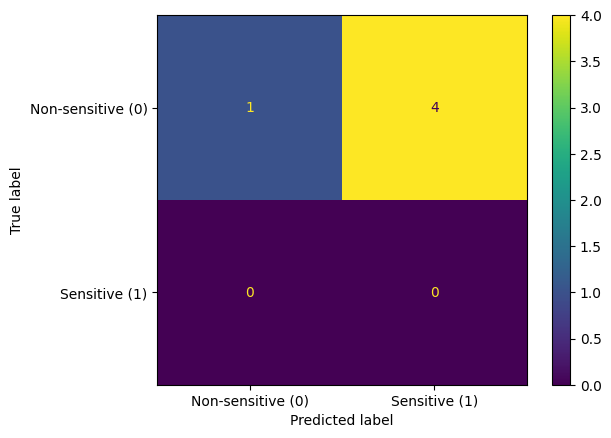

In [67]:
mr = main_experiment('x', 10, True, b1, '\n[/INST]', tokenizer, model, first_5)


In [68]:
mr

{'114715_0': '\n[/INST] \nResponse: The text does not contain personal information. It is a professional message',
 '114715_1': '\n[/INST] \nResponse: The text does contain personal information in a professional context. The message',
 '114715_2': '\n[/INST] \nResponse: The text does contain personal information in a professional context. The message',
 '229405_0': '\n[/INST] \nResponse: The text does contain personal information in a professional context. The message',
 '229405_1': '\n[/INST] \nResponse: The text does not contain personal information. The message is about Southern',
 '229405_2': '\n[/INST] \nResponse: The text does not contain personal information. The link to the article',
 '232795_0': '\n[/INST] \nResponse: The text does not contain personal information. The forwarded message does',
 '232795_1': '\n[/INST] \nResponse: The text does not contain personal information. The message is related to',
 '62815_0': '\n[/INST] \nResponse: The text does contain personal informat